<a href="https://colab.research.google.com/github/fenom/Coursera_Capstone/blob/master/Capstone_The_Battle_of_the_Neighborhoods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project, we try to help an airline decide where to establish its hubs. Specifically, this report will be targeted to stakeholders interested in servicing the **top airports** in the **United States**.

Locations of airports in relation to each other is one of the deciding factors of the locations of hubs. We will **group airports into clusters** so that each one will be serviced by one hub.

## Data <a name="data"></a>

We use Foursquare API to obtain a list of top airports and their locations in the United States.

### Airports

Let's do a search on Foursquare API for top airports in the United States, then trim down the data to only what we need, latitude & longitude coordinates.

We specify the category ID for airports when we make the API call. However, there are subcategories under the "Airport" category, and Foursquare API always include subcategories in searches. We simply discard venues that aren't airports.

We are not concerned about the exact number of airports or the specific airports. We just want some data our model.

In [0]:
%matplotlib inline

In [0]:
import pandas as pd
import numpy as np
import requests
from pandas.io.json import json_normalize

VERSION = '20180604'
LIMIT = 50

latitude = 39.76
longitude = -98.5
near = 'USA'
intent = 'browse'
categoryId = '4bf58dd8d48988d1ed931735'
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&v={}&near={}&intent={}&categoryId={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION, near, intent, categoryId, LIMIT)
results = requests.get(url).json()
lat = results['response']['geocode']['feature']['geometry']['center']['lat']
lng = results['response']['geocode']['feature']['geometry']['center']['lng']

venues = results['response']['venues']

dataframe = json_normalize(venues)
dataframe.head()

filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered = dataframe_filtered[dataframe_filtered.categories == 'Airport']

df = dataframe_filtered[['name', 'lat', 'lng']].reset_index().drop('index', axis=1)
print(dataframe_filtered.shape)
df

(29, 15)


,name,lat,lng
0,John F. Kennedy International Airport (JFK) (J...,40.645122,-73.784609
1,San Francisco International Airport (SFO) (San...,37.616713,-122.387094
2,Los Angeles International Airport (LAX) (Los A...,33.943324,-118.405602
3,Chicago O'Hare International Airport,41.977072,-87.901182
4,Hartsfield-Jackson Atlanta International Airpo...,33.640544,-84.433408
5,Newark Liberty International Airport (EWR) (Ne...,40.692971,-74.177992
6,LaGuardia Airport (LGA) (LaGuardia Airport),40.772888,-73.868809
7,Dallas Fort Worth International Airport (DFW) ...,32.899191,-97.040048
8,Seattle-Tacoma International Airport (SEA) (Se...,47.443589,-122.302508
9,Denver International Airport (DEN) (Denver Int...,39.849733,-104.673982


Let's just see the airports on a map.

In [0]:
#!pip install folium

import folium

In [0]:
map = folium.Map(location=[lat, lng], zoom_start=4)

for lat, lng, label in zip(df.lat, df.lng, df.name):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(map)

map

Let's see them on a scatter plot where we're at it.

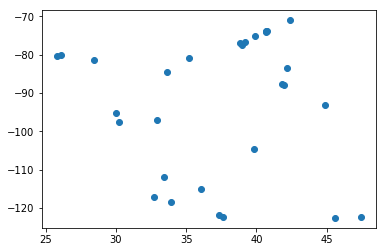

In [0]:
import matplotlib.pyplot as plt 

plt.scatter(df.lat, df.lng, marker='o')

## Methodology <a name="methodology"></a>

We will use **Hierarchical Agglomerative Clustering** on the airports.

## Analysis <a name="analysis"></a>

First we prepare a **distance matrix**.

In [0]:
from scipy.spatial import distance_matrix 

dist_matrix = distance_matrix(df[['lat', 'lng']],df[['lat', 'lng']]) 
dist_matrix

array([[ 0.        , 48.69674396, 45.12147071, 14.17927122, 12.74602016,
         0.39628293,  0.15301578, 24.51152537, 48.99189445, 30.89961182,
        16.20725735,  3.25694347, 41.6082255 , 24.05327265, 14.34511915,
        19.88359183,  4.03667932,  9.69870429,  1.64801533,  8.98242906,
        38.89457586, 44.13160126,  3.71769686, 15.89980828, 26.06564213,
        49.05852354,  3.23618881, 48.25231844, 14.00436154],
       [48.69674396,  0.        ,  5.41720102, 34.76047864, 38.16139744,
        48.30715161, 48.62083395, 25.78231556,  9.82723957, 17.85331161,
        43.73676368, 51.58721103,  7.40542211, 28.09512698, 42.09403176,
        30.06690645, 44.95923011, 39.29982584, 47.19890497, 41.51224353,
        11.19267248,  7.1238726 , 45.36162578, 43.79285212, 25.80819526,
         7.97483492, 45.74414838,  0.52558791, 34.89497361],
       [45.12147071,  5.41720102,  0.        , 31.54458307, 33.97354345,
        44.7396825 , 45.05739554, 21.39105247, 14.05144165, 14.94801158,
  

Then we create the **linkage**.

In [0]:
from scipy.cluster import hierarchy

Z = hierarchy.linkage(dist_matrix, 'complete')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  This is separate from the ipykernel package so we can avoid doing imports until


Now we can display the clustering in a **dendrogram**.

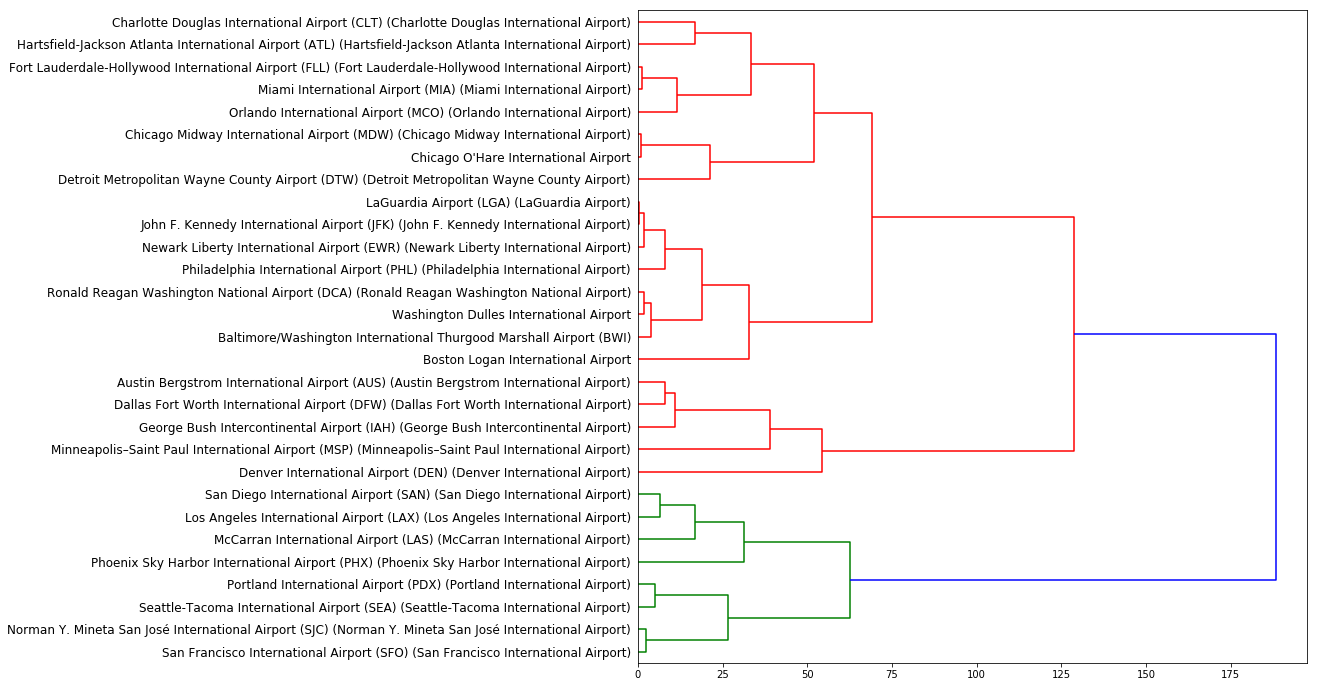

In [0]:
import pylab

fig = pylab.figure(figsize=(12,12))
dendro = hierarchy.dendrogram(Z, leaf_label_func=lambda x: df.name[x], leaf_font_size=12, orientation='right')

## Results and Discussion <a name="results"></a>

Thus we have demonstrated a method of clustering airports by distances, regardless of the airports or the number of them. We can see what the clusters look like depending on the number of hubs.

## Conclusion <a name="conclusion"></a>

An airline can now use the method put forth by this report as part of the decision on where place each hub, however many it wishes to have.